# XGBoost Sin Stock

In [24]:
import pandas as pd # Data handling and managing
import numpy as np  # Handiling linear Algera
import seaborn as sn
import datetime 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import xgboost as xgb #xgboost model
import pmdarima as pm
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [25]:
dataset=pd.read_excel(r'C:\Users\subir\OneDrive\Escritorio\PC ANTIC\UOC\TFM\Dataset_Completo_Fase2.xlsx')
dataset.drop(dataset.columns[0], axis=1, inplace=True)
dataset

,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana
0,2015-06-29,1,3629,0,4.394742,0,0
1,2015-06-30,1,4666,0,4.394742,0,0
2,2015-07-01,1,16070,0,4.394742,0,0
3,2015-07-02,1,4666,0,4.394742,0,0
4,2015-07-03,1,8813,0,4.394742,0,0
...,...,...,...,...,...,...,...
140541,2021-03-19,99,540,0,4.394742,0,0
140542,2021-03-20,99,0,0,4.394742,0,1
140543,2021-03-21,99,0,0,4.394742,0,1
140544,2021-03-22,99,0,0,4.394742,0,0


In [26]:
#Tratamiento Outliers
Q1_ventas=dataset['udsVenta'].quantile(0.25)
Q3_ventas=dataset['udsVenta'].quantile(0.75)
IQR_ventas=Q3_ventas-Q1_ventas

Limit_lower=Q1_ventas-(1.5*IQR_ventas)
Limit_upper=Q3_ventas+(1.5*IQR_ventas)

dataset=dataset[~((dataset["udsVenta"] < Limit_lower) |(dataset["udsVenta"] > Limit_upper))]


Q1_precios=dataset['Precio'].quantile(0.25)
Q3_precios=dataset['Precio'].quantile(0.75)
IQR_precios=Q3_precios-Q1_precios

Limit_lower_precios=Q1_precios-(1.5*IQR_precios)
Limit_upper_precios=Q3_precios+(1.5*IQR_precios)

dataset=dataset[~((dataset["Precio"] < Limit_lower_precios) |(dataset["Precio"] > Limit_upper_precios))]

In [27]:
#División TEST y TRAINING

X_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1)
y_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019'), 'udsVenta']

X_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1).reset_index(drop=True)
y_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019'), 'udsVenta'].reset_index(drop=True)

In [ ]:
#Busqueda parametros optimos

from sklearn.model_selection import GridSearchCV

gbm_param_grid = {
     'colsample_bytree': np.linspace(0.5, 0.9, 5),
     'n_estimators':[100, 200,500],
     'max_depth': [10, 15, 20, 25]
}

grid_mse = GridSearchCV(estimator = reg, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)

grid_mse.fit(X_train, y_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [28]:
#Aplicación del modelo con parametros optimos
from xgboost import XGBRegressor

reg = XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=10, colsample_bytree=0.8)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],eval_metric='mae')

[0]	validation_0-mae:459.69513	validation_1-mae:360.86523
[1]	validation_0-mae:455.92227	validation_1-mae:358.82309
[2]	validation_0-mae:453.59592	validation_1-mae:357.88849
[3]	validation_0-mae:449.96027	validation_1-mae:355.89240
[4]	validation_0-mae:446.37234	validation_1-mae:353.92709
[5]	validation_0-mae:442.76502	validation_1-mae:351.99506
[6]	validation_0-mae:440.55347	validation_1-mae:351.14017
[7]	validation_0-mae:437.07425	validation_1-mae:349.26312
[8]	validation_0-mae:433.63336	validation_1-mae:347.42200
[9]	validation_0-mae:430.52039	validation_1-mae:345.62878
[10]	validation_0-mae:427.09445	validation_1-mae:343.86816
[11]	validation_0-mae:423.85684	validation_1-mae:342.28742
[12]	validation_0-mae:420.84760	validation_1-mae:340.60928
[13]	validation_0-mae:418.81207	validation_1-mae:339.88260
[14]	validation_0-mae:415.57828	validation_1-mae:338.20807
[15]	validation_0-mae:412.46417	validation_1-mae:336.69910
[16]	validation_0-mae:409.24576	validation_1-mae:335.11050
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=24, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
#Evaluacion resultados

from sklearn.model_selection import cross_val_score, KFold 
from sklearn.metrics import mean_squared_error

ypred = reg.predict(X_test)

mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 165930.19
RMSE: 407.35


C:\Users\subir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


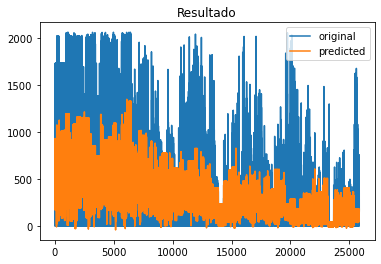

In [30]:
#Plot resultado vs real

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Resultado")
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

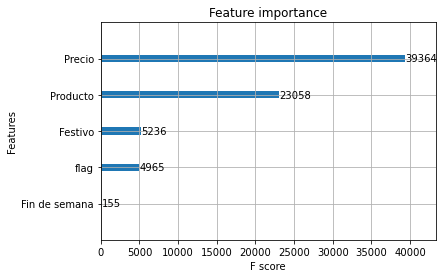

In [31]:
#Peso variables

from xgboost import plot_importance
plot_importance(reg)

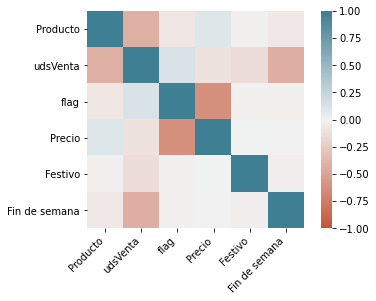

In [32]:
#Correlacion variables

corr = dataset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [11]:
#Muestra dataset con variable predicha
resultat = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019')]
resultat['prediccion']=ypred
resultat

<ipython-input-11-46d73cf30b6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultat['prediccion']=ypred


,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana,prediccion
1648,2019-12-31,1,691,0,3.910500,0,0,927.461060
1649,2020-01-01,1,0,0,3.910500,1,0,170.096909
1652,2020-01-04,1,346,0,3.910500,0,1,182.990860
1653,2020-01-05,1,0,0,3.910500,0,1,182.990860
1654,2020-01-06,1,0,0,3.910500,1,0,170.096909
...,...,...,...,...,...,...,...,...
140541,2021-03-19,99,540,0,4.394742,0,0,176.732300
140542,2021-03-20,99,0,0,4.394742,0,1,45.435760
140543,2021-03-21,99,0,0,4.394742,0,1,45.435760
140544,2021-03-22,99,0,0,4.394742,0,0,176.732300


# XGBoost con variables extras

In [33]:
import pandas as pd # Data handling and managing
import numpy as np  # Handiling linear Algera
import seaborn as sn
import datetime 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import xgboost as xgb #xgboost model
import pmdarima as pm
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [50]:
dataset=pd.read_excel(r'C:\Users\subir\OneDrive\Escritorio\PC ANTIC\UOC\TFM\Dataset_Completo_Fase3.xlsx')
dataset.drop(dataset.columns[0], axis=1, inplace=True)
dataset

,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana,sales_lag_7,sales_lag_15,sales_lag_30,...,sales_lag_300,sales_lag_330,sales_lag_360,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,Mes,Dia,DiaDeLaSemana,Año
0,2019-02-20,1,1555,0,4.138200,0,0,0,1555,518,...,0,0,0,121.425704,94.570180,86.954522,2,20,2,2019
1,2019-02-23,1,1037,0,4.138200,0,1,1037,1037,0,...,0,0,0,122.785716,95.307368,87.471774,2,23,5,2019
2,2019-02-24,1,0,0,4.138200,0,1,0,0,0,...,0,0,0,124.180002,96.063975,88.001770,2,24,6,2019
3,2019-02-27,1,1037,0,4.138200,0,0,518,1037,0,...,0,0,0,125.577704,96.826398,88.532477,2,27,2,2019
4,2019-03-02,1,518,0,4.138200,0,1,0,0,1037,...,0,0,0,127.009914,97.594623,89.063859,3,2,5,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105951,2021-03-19,99,540,0,4.394742,0,0,0,0,756,...,0,0,0,198.518439,218.510439,201.719088,3,19,4,2021
105952,2021-03-20,99,0,0,4.394742,0,1,0,0,0,...,540,0,108,197.608648,218.441607,201.748880,3,20,5,2021
105953,2021-03-21,99,0,0,4.394742,0,1,0,0,0,...,0,0,0,196.698856,218.366616,201.782522,3,21,6,2021
105954,2021-03-22,99,0,0,4.394742,0,0,0,0,0,...,810,0,0,195.789065,218.287277,201.817988,3,22,0,2021


In [51]:
#Tratamiento Outliers
#EN la creacion de dataset se han tratado los outliers de ventas ya
Q1_precios=dataset['Precio'].quantile(0.25)
Q3_precios=dataset['Precio'].quantile(0.75)
IQR_precios=Q3_precios-Q1_precios

Limit_lower_precios=Q1_precios-(1.5*IQR_precios)
Limit_upper_precios=Q3_precios+(1.5*IQR_precios)

dataset=dataset[~((dataset["Precio"] < Limit_lower_precios) |(dataset["Precio"] > Limit_upper_precios))]

In [37]:
#Solo para buscar parametros optimos
#dataset = dataset.sample(frac=0.20)

In [52]:
#División TEST y TRAINING

X_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1)
y_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019'), 'udsVenta']

X_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1).reset_index(drop=True)
y_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019'), 'udsVenta'].reset_index(drop=True)

In [39]:
#Solo para buscar parametros optimos
from sklearn.model_selection import GridSearchCV

reg = XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=10, colsample_bytree=0.8)

gbm_param_grid = {
     'colsample_bytree': np.linspace(0.5, 0.9, 5),
     'n_estimators':[100, 200,500],
     'max_depth': [10, 15, 20, 25]
}

grid_mse = GridSearchCV(estimator = reg, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)


#Solo para buscar parametros optimos
grid_mse.fit(X_train, y_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\subir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\subir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\subir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\subir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\subir\anaconda3\lib\si

Best parameters found:  {'colsample_bytree': 0.7, 'max_depth': 10, 'n_estimators': 500}
Lowest RMSE found:  253.88640371858256


In [53]:
#Aplicación del modelo con parametros optimos

from xgboost import XGBRegressor

reg = XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=10, colsample_bytree=0.7)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],eval_metric='rmse')

[0]	validation_0-rmse:673.75635	validation_1-rmse:610.40826
[1]	validation_0-rmse:668.03693	validation_1-rmse:605.90253
[2]	validation_0-rmse:662.30457	validation_1-rmse:601.23730
[3]	validation_0-rmse:656.71637	validation_1-rmse:596.98584
[4]	validation_0-rmse:651.14685	validation_1-rmse:592.46313
[5]	validation_0-rmse:645.55926	validation_1-rmse:587.95697
[6]	validation_0-rmse:640.14325	validation_1-rmse:583.73212
[7]	validation_0-rmse:634.71075	validation_1-rmse:579.68616
[8]	validation_0-rmse:629.44495	validation_1-rmse:575.58197
[9]	validation_0-rmse:624.24225	validation_1-rmse:571.91504
[10]	validation_0-rmse:619.06927	validation_1-rmse:568.10523
[11]	validation_0-rmse:613.82440	validation_1-rmse:563.95178
[12]	validation_0-rmse:608.75586	validation_1-rmse:560.03668
[13]	validation_0-rmse:603.66461	validation_1-rmse:556.14447
[14]	validation_0-rmse:598.77582	validation_1-rmse:552.49969
[15]	validation_0-rmse:593.79254	validation_1-rmse:548.66974
[16]	validation_0-rmse:588.82471	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=24, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
#Evaluacion resultados

ypred = reg.predict(X_test)

mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 146779.97
RMSE: 383.12


C:\Users\subir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [19]:
score = reg.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.8757218013705762


C:\Users\subir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


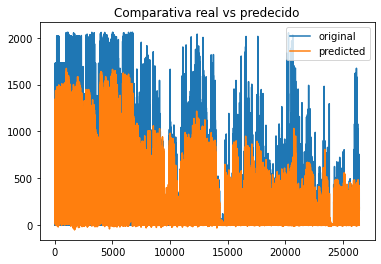

In [55]:
#Plot resultado vs real

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Comparativa real vs predecido")
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

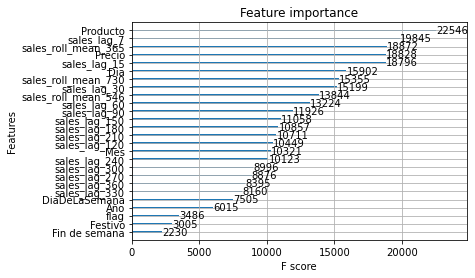

In [48]:
#Peso variables

from xgboost import plot_importance
plot_importance(reg)

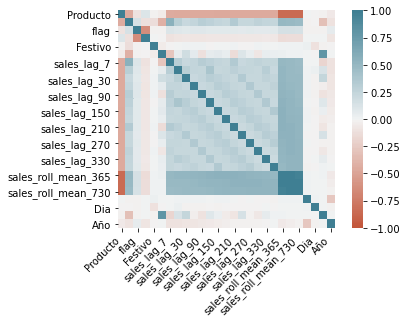

In [49]:
#Correlacion variables

corr = dataset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [23]:
dataset.corr()

,Producto,udsVenta,flag,Precio,Festivo,Fin de semana,sales_lag_7,sales_lag_15,sales_lag_30,sales_lag_60,...,sales_lag_300,sales_lag_330,sales_lag_360,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,Mes,Dia,DiaDeLaSemana,Año
Producto,1.000000,-0.444477,-0.096480,0.115576,-0.012018,-0.041628,-0.444459,-0.446796,-0.451906,-0.452604,...,-0.451577,-0.450483,-0.447352,-0.849101,-0.852680,-0.854346,0.005358,-0.002574,-0.020481,-0.057460
udsVenta,-0.444477,1.000000,0.146850,-0.115141,-0.121293,-0.419418,0.560658,0.309899,0.218852,0.254821,...,0.267992,0.253017,0.247680,0.503722,0.487007,0.473636,-0.021797,-0.005021,-0.313336,-0.094066
flag,-0.096480,0.146850,1.000000,-0.634393,-0.008492,-0.022668,0.115640,0.089129,0.083814,0.088176,...,0.075961,0.073076,0.083739,0.150831,0.149304,0.146975,-0.010195,-0.011946,-0.022139,0.047694
Precio,0.115576,-0.115141,-0.634393,1.000000,0.001397,-0.000612,-0.095317,-0.079433,-0.076537,-0.080402,...,-0.062645,-0.060512,-0.064779,-0.133882,-0.127009,-0.124781,0.001426,0.004926,0.006120,-0.081366
Festivo,-0.012018,-0.121293,-0.008492,0.001397,1.000000,-0.041959,-0.004626,0.002997,0.013321,0.008128,...,0.010168,0.005160,0.003157,0.010213,0.008801,0.008311,0.026933,-0.101660,-0.007917,-0.002626
Fin de semana,-0.041628,-0.419418,-0.022668,-0.000612,-0.041959,1.000000,-0.288623,0.059871,0.183215,0.069324,...,-0.073193,0.040807,0.033592,0.024489,0.022331,0.020603,0.000306,-0.001518,0.798694,0.003628
sales_lag_7,-0.444459,0.560658,0.115640,-0.095317,-0.004626,-0.288623,1.000000,0.315825,0.220566,0.253681,...,0.264007,0.248109,0.247734,0.505806,0.488359,0.474639,0.004392,0.000042,-0.182715,-0.099765
sales_lag_15,-0.446796,0.309899,0.089129,-0.079433,0.002997,0.059871,0.315825,1.000000,0.309679,0.253285,...,0.238881,0.313714,0.223970,0.509435,0.491949,0.478101,0.014734,0.025228,0.137056,-0.095691
sales_lag_30,-0.451906,0.218852,0.083814,-0.076537,0.013321,0.183215,0.220566,0.309679,1.000000,0.222722,...,0.239970,0.271073,0.254829,0.515528,0.498394,0.484489,0.016290,-0.022901,0.247333,-0.081589
sales_lag_60,-0.452604,0.254821,0.088176,-0.080402,0.008128,0.069324,0.253681,0.253285,0.222722,1.000000,...,0.228923,0.238907,0.269201,0.524043,0.504789,0.489979,0.018680,-0.014932,-0.023548,-0.080092


In [56]:
#Muestra dataset con variable predicha
resultat = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019')]
resultat['prediccion']=ypred
resultat

<ipython-input-56-46d73cf30b6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultat['prediccion']=ypred


,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana,sales_lag_7,sales_lag_15,sales_lag_30,...,sales_lag_330,sales_lag_360,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,Mes,Dia,DiaDeLaSemana,Año,prediccion
184,2019-12-31,1,691,0,3.910500,0,0,1382,0,1382,...,0,0,535.044701,331.188730,231.598390,12,31,1,2019,910.051575
185,2020-01-01,1,0,0,3.910500,1,0,0,346,0,...,518,0,536.871361,333.166789,232.649637,1,1,2,2020,203.423706
186,2020-01-04,1,346,0,3.910500,0,1,0,0,1382,...,0,0,538.698020,335.146950,233.702512,1,4,5,2020,489.044006
187,2020-01-05,1,0,0,3.910500,0,1,346,1728,1382,...,0,0,540.473081,337.110803,234.755551,1,5,6,2020,66.021889
188,2020-01-06,1,0,0,3.910500,1,0,0,1728,346,...,0,0,542.217206,339.056112,235.808783,1,6,0,2020,348.442596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105951,2021-03-19,99,540,0,4.394742,0,0,0,0,756,...,0,0,198.518439,218.510439,201.719088,3,19,4,2021,209.790512
105952,2021-03-20,99,0,0,4.394742,0,1,0,0,0,...,0,108,197.608648,218.441607,201.748880,3,20,5,2021,90.209129
105953,2021-03-21,99,0,0,4.394742,0,1,0,0,0,...,0,0,196.698856,218.366616,201.782522,3,21,6,2021,-1.539106
105954,2021-03-22,99,0,0,4.394742,0,0,0,0,0,...,0,0,195.789065,218.287277,201.817988,3,22,0,2021,175.692352


In [57]:
resultat.to_excel(r'C:\Users\subir\OneDrive\Escritorio\PC ANTIC\UOC\TFM\Resultado_final.xlsx')